# On Parametric Optimal Execution and Machine Learning Surrogates

In [1]:
# Authors: Tao Chen, Mike Ludkovski, Moritz Voss 
# Version: 2.0 (12/09/2023)
# License: MIT
# Email: voss@math.ucla.edu

## Overview

The purpose of this notebook is to implement a (deep) neural network approximator for the optimal execution problem with nonlinear price impact, stochastic resilience and inventory penalty (see <a href="https://arxiv.org/abs/2204.08581">On Parametric Optimal Execution and Machine Learning Surrogates</a> by Tao Chen, Mike Ludkovski, and Moritz Voß). The neural network surrogate provides a parametric solver that organically incorporates model parameters as additional inputs. Thus, the resulting solution is not only a function of the system state, but also a function of the chosen static model parameters, allowing analysis of the respective sensitivity and stability. This is critical for optimal execution where several model parameters are abstract and difficult to calibrate, making model risk significant.

The output of this notebook shows a typical 5-dimensional parametric surrogate that learns the value function and optimal control as a function of $(x,d,\kappa, \eta, \alpha)$. It matches Figure 4 in the article.

In [2]:
import numpy as np

from scipy import optimize

import LinearModel as LF

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import TruncatedNormal

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import time
from datetime import datetime
from pytz import timezone

Check versions (optional):

In [3]:
import scipy
import sklearn
import matplotlib

from platform import python_version
print(python_version())
print(np.__version__)
print(scipy.__version__)
print(tf.__version__)
print(tf.keras.__version__)
print(sklearn.__version__)
print(matplotlib.__version__)

3.9.5
1.20.3
1.7.1
2.4.1
2.4.0
0.24.2
3.4.2


## 1. Create General Setup


### Define state-action value function for learning

Value function at final time step $n=N$ is given by
\begin{equation}
V_N(x_{N-1},d_{N-1}) \triangleq (1-\kappa) d_{N-1} x_{N-1} + \frac{\eta}{2} |x_{N-1}|^{\alpha+1}.
\end{equation}

Corresponding optimal policy is given by
\begin{equation}
u^*_N(x_{N-1}, d_{N-1}) = x_{N-1}.
\end{equation}

In [4]:
def ValueFunctionTerminal(x, d, kappa, eta, alpha, nu):
    
    return (1-kappa) * d * x + eta/2 * np.power(np.abs(x), alpha + 1)

State-action value function at time step $n = N-1$:

In [5]:
def StateActionValueFunctionTerminal(xi, x, d, kappa, eta, alpha, nu, quantizer):
    
    vec = (1-kappa) * d * xi + eta/2 * np.power(np.abs(xi), alpha + 1) + nu * (x - xi)**2 \
            + ValueFunctionTerminal(x - xi,
                                    (1-kappa) * d + eta * np.power(np.abs(xi), alpha) * np.sign(xi) + quantizer[1],
                                    kappa, eta, alpha, nu) 
    
    return np.sum(vec * quantizer[0])

The NN predictor for policy and value function works with rescaled inputs and outputs, both of which are mapped into $[0,1]$. To scale the value function we use the <tt>MinMaxScaler</tt> objects in _TensorFlow_. To scale the control, we divide by the current inventory remaining to fill. Since controls are constrained to be positive (a strictly buying program) at all steps, this again scales into $[0,1]$.

We construct this predictor manually for both **value function** and **policy**, *for each timestep*  in order to maximize speed and also make clear the format of the NN surrogate, which consists of taking the dot product between NN weights and the neuron inputs at each layer, and then transforming with the ELU activation function. 

The first line scales the inputs, and the last line rescales back the NN output.


In [6]:
def Predictor(x, d, kappa, eta, alpha, nu, nnweights, inputscaler, outputscaler, scaleOutput = 1):
    
    # if scaleOutput = 0 then use sigmoid activation and no output scaler
    # x, d are (number, ) arrays 
    
    inputdata = np.concatenate((x.reshape(-1,1),
                                d.reshape(-1,1),
                                kappa.reshape(-1,1),
                                eta.reshape(-1,1),
                                alpha.reshape(-1,1), 
                                nu.reshape(-1,1)), axis = 1)
    
    inputdata = inputscaler.transform(inputdata)
    
    layer1out = np.dot(inputdata, nnweights[0]) + nnweights[1]
    
    layer1out = tf.keras.activations.elu(layer1out).numpy()
    
    layer2out = np.dot(layer1out, nnweights[2]) + nnweights[3]
    
    layer2out = tf.keras.activations.elu(layer2out).numpy()
    
    layer3out = np.dot(layer2out, nnweights[4]) + nnweights[5]
    
    layer3out = tf.keras.activations.elu(layer3out).numpy()
    
    layer4out = np.dot(layer3out, nnweights[6]) + nnweights[7]
    
    if scaleOutput == 0:   # for policy apply sigmoid
        output = tf.keras.activations.sigmoid(layer4out).numpy() 
    
    if scaleOutput == 1:   # for value function apply output scaler
        output = outputscaler.inverse_transform(layer4out)
    
    return output

The <b>value function</b> at time step $n = N-1,\ldots,1$ as a function in the two state variables $(x,d)$ satisfies DPP equation

\begin{align}
V_{n}(x,d) = & \, \min_{u \in [0,x]} \mathbb{E}\left[ (1-\kappa) d u + \frac{1}{2} \eta \vert u \vert^{\alpha+1} + \nu (x- u)^2 +  V_{n+1}(X_{n-1}-u,D_{n}) \; \bigg\vert \; X_{n-1}=x, D_{n-1}=d \right] \\
= & \, \min_{u \in [0,x]} \left\{ (1-\kappa) d u + \frac{\eta}{2} \vert u \vert^{\alpha+1}  + \nu (x - u)^2 + \mathbb{E}\left[ V_{n+1}(X_{n-1}-u, (1-\kappa) D_{n-1} + \eta \vert u \vert^\alpha \text{sign}(u) + \epsilon_n) \; \vert \; X_{n-1}=x, D_{n-1}=d \right] \right\} \\
= & \, \min_{u \in [0,x]} \left\{ (1-\kappa) d u + \frac{\eta}{2} \vert u \vert^{\alpha+1}  + \nu (x - u)^2 + \mathbb{E}\left[ V_{n+1}(x-u, (1-\kappa) d + \eta \vert u \vert^\alpha \text{sign}(u) + \epsilon_n) \; \vert \; X_{n-1}=x, D_{n-1}=d \right] \right\},
\end{align}

where $\epsilon_n \sim\mathcal{N}(0,\sigma^2)$ independent of $X_{n-1}, D_{n-1}$. Consequently, we get

\begin{align}
\mathbb{E}\left[ V_{n+1} \left(x-u, (1-\kappa) d + \eta \vert u \vert^\alpha \text{sign}(u) + \epsilon_n \right) \; \vert \; X_{n-1}=x, D_{n-1}=d \right] \approx & \, \sum_{j=1}^{N'} w^j \cdot V_{n+1} \left(x - u, (1-\kappa)d + \eta \vert u\vert^\alpha \text{sign}(u) + \sigma z^j 
\right),
\end{align}

where $(z^j)_{j=1,\ldots,N'}$ is a 1-dim. quantization of $Z\sim\mathcal{N}(0,1)$ with weights $(w^j)_{j=1,\ldots,N'}$.

Now, for some <i>experimental design points</i> $((x^m_{n-1},d^m_{n-1}))_{m=1,\ldots,M}$, which represent the <b>training input data</b>, the corresponding <b>training output data</b> $(\hat{v}^m_{n-1})_{m=1,\ldots,M}$ for the <b>value function surrogate</b> and $(\hat{u}^m_{n-1})_{m=1,\ldots,M}$ for the <b>policy surrogate</b> at step $n$ is based on the pointwise computations
\begin{align}
\hat{v}^m_{n} := & \, \min_{\xi \in [0,x_{n-1}^m]} \underbrace{\left\{ (1-\kappa) d^m_{n-1} \xi + \frac{\eta}{2} \vert \xi\vert^{\alpha+1} + \nu (x^m_{n-1} - \xi)^2 + \sum_{j=1}^{N'} w^j \cdot \widehat{V}_{n+1} \left( x^{m}_{n-1} - \xi, (1-\kappa) d^m_{n-1} + \eta  \vert\xi\vert^\alpha \text{sign}(\xi) + \sigma z^j \right)  \right\}}_{=\,\texttt{StateActionValueFunction}(\cdot)}
\end{align}
and
\begin{align}
\hat{u}^m_{n} := & \, \text{arg}\min_{\xi \in [0,x_{n-1}^m]} \underbrace{\left\{ (1-\kappa) d^m_{n-1} \xi + \frac{\eta}{2} \vert \xi\vert^{\alpha+1} + \nu (x^m_{n-1} - \xi)^2 + \sum_{j=1}^{N'} w^j \cdot \widehat{V}_{n+1} \left( x^{m}_{n-1} - \xi, (1-\kappa) d^m_{n-1} + \eta  \vert\xi\vert^\alpha \text{sign}(\xi) + \sigma z^j \right) \right\}}_{=\,\texttt{StateActionValueFunction}(\cdot)}.
\end{align}

for all $m=1,\ldots,M$. 

<b>Comment:</b> Note that everything can be augmented in a straightforward way to a 5-dimensional training input data $((x^m_{n-1},d^m_{n-1},\kappa^m_{n-1},\eta^m_{n-1},\alpha^m_{n-1}))_{m=1,\ldots,M}$, i.e., including also the model parameters $\kappa, \eta, \alpha$.

In [7]:
def StateActionValueFunction(xi, x, d, kappa, eta, alpha, nu, nnweights, inputscaler, outputscaler, quantizer):
    
    # quantizer already scaled by sigma
    
    numWeights = len(quantizer[0])
    
    vec = (1-kappa) * d * xi + eta/2 * np.power(np.abs(xi), alpha + 1) + nu * (x - xi)**2 \
            + Predictor(np.ones(numWeights) * (x - xi),
                        (1-kappa) * d + eta * np.power(np.abs(xi), alpha) * np.sign(xi) + quantizer[1],
                        np.ones(numWeights) * kappa,
                        np.ones(numWeights) * eta,
                        np.ones(numWeights) * alpha,
                        np.ones(numWeights) * nu,
                        nnweights, inputscaler, outputscaler)
    
    return np.sum(vec.flatten() * quantizer[0])

### Define neural network training function

The NN surrogate $f^{\theta_n} \equiv \hat{V}_{n}(\cdot;\theta_n)$ for the **value function** is trained by optimizing for the respective hyperparameters $\theta_{n}$ (using the Adam algorithm) the squared error 

\begin{equation}
\sum_{m=1}^M \left( f^{\theta_{n}}(x^m_{n-1},d^m_{n-1}) - \hat{v}^m_{n} \right)^2 \rightarrow \min_{\theta_{n}}
\end{equation}

The value function approximation (prediction) at $n$ is then given by

\begin{equation}
\hat{V}_n(x,d;\theta^*_n) := f^{\theta^*_{n}}(x,d),
\end{equation}

with optimized NN parameters $\theta^*_n$. 

We use an NN with three hidden layers, <tt>node_num</tt> nodes, exponential linear unit activation function _ELU_  and $\mathcal{N}(0,1)$ initialization for $\theta_{n}$.

We also rescale training **inputs** $((x^m_{n-1},d^m_{n-1}))_{m=1,\ldots,M}$ and training **outputs** $(\hat{v}^m_{n})_{m=1,\ldots,M}$ to the interval $[0,1]$.

Same logic is done for training the neural network for the **control**, except the output layer is subject to a sigmoid transformation and the NN prediction is interpreted as the fraction of current remaining inventory to buy:

\begin{equation}
\sum_{m=1}^M \left( g^{\vartheta_{n}}(x^m_{n-1},d^m_{n-1}) - \hat{u}^{m}_{n}/x^m_{n-1} \right)^2 \rightarrow \min_{\vartheta_{n}}
\end{equation}

The policy approximation (prediction) at $n$ is then given by

\begin{equation}
\hat{u}_n(x,d;\vartheta^*_n) := g^{\vartheta^*_{n}}(x,d) \cdot x
\end{equation}

with optimized NN parameters $\vartheta^*_n$. 

In [8]:
def BuildAndTrainModel(x_train, d_train, kappa_train, eta_train, alpha_train, nu_train, 
                       quantizer,
                       nn_dim = 6, node_num = 20, batch_num = 64, epoch_num = 3000,
                       initializer = TruncatedNormal(mean = 0.0, stddev = 0.05, seed = 0)):
        
    # Create training input and rescale
    numTrain = len(x_train)
    
    
    input_train = np.concatenate((x_train.reshape(-1,1),
                                  d_train.reshape(-1,1),
                                  kappa_train.reshape(-1,1),
                                  eta_train.reshape(-1,1),
                                  alpha_train.reshape(-1,1),
                                  nu_train.reshape(-1,1)), axis = 1) # (M_train, 6) array
    
    input_scaler = MinMaxScaler(feature_range = (0,1))
    input_scaler.fit(input_train)
    input_train_scaled = input_scaler.transform(input_train)
    
    valuefun_train = np.zeros((N+1, numTrain))
    policy_train = np.zeros((N+1, numTrain))
    
    
    # Create objects to save all NN solvers and scalers     
    output_scaler_valuefun = np.empty(N+1, dtype = object)
    nnsolver_valuefun = np.empty(N+1, dtype = object)
    nnsolver_policy = np.empty(N+1, dtype = object)
    
    start = time.perf_counter() 

    
    # Run through all time steps backwards 
    for j in range(N-1, 0, -1):
        
        start_i = time.perf_counter()
        print("Time step " + str(j))
        
        
        # Create training output for value function and policy
        for i in range(numTrain):
            
            if j < (N-1):
                f_i = lambda xi: StateActionValueFunction(xi, x_train[i], d_train[i], kappa_train[i],
                                    eta_train[i], alpha_train[i], nu_train[i],
                                    nnsolver_valuefun[j+1].get_weights(),
                                    input_scaler, output_scaler_valuefun[j+1], 
                                    quantizer)
            
            else:
            
                f_i = lambda xi: StateActionValueFunctionTerminal(xi, x_train[i], d_train[i],
                                      kappa_train[i], eta_train[i], alpha_train[i], nu_train[i],
                                      quantizer)
            
            # Minimize state-action value function on the interval [0,X]
            solf_i = optimize.minimize_scalar(f_i, bounds=(0, x_train[i]), method='bounded')
        
            policy_train[j][i] = solf_i.x / x_train[i]
            valuefun_train[j][i] = solf_i.fun
        
        end_i = time.perf_counter()
        print("     optimizations done: " + str(round((end_i-start_i)/60,2)) + " min.")
        

        start_i = time.perf_counter()
                
            
        # Build and train NN model for value function    
        output_scaler_valuefun[j] = MinMaxScaler(feature_range = (0,1))
        output_scaler_valuefun[j].fit(valuefun_train[j].reshape(-1, 1))
        valuefun_train_scaled = output_scaler_valuefun[j].transform(valuefun_train[j].reshape(-1,1))     
        
        nnsolver_valuefun[j] = Sequential()    
        nnsolver_valuefun[j].add(Dense(node_num, input_shape = (nn_dim,), activation = 'elu',
                                    kernel_initializer = initializer, bias_initializer = initializer))            
        nnsolver_valuefun[j].add(Dense(node_num, activation = 'elu',
                                    kernel_initializer = initializer, bias_initializer = initializer))
        nnsolver_valuefun[j].add(Dense(node_num, activation = 'elu',
                                    kernel_initializer = initializer, bias_initializer = initializer))
        nnsolver_valuefun[j].add(Dense(1, activation = None,
                                    kernel_initializer = initializer, bias_initializer = initializer))
        
        nnsolver_valuefun[j].compile(optimizer = 'adam', loss = 'mean_squared_error')
        nnsolver_valuefun[j].fit(input_train_scaled, valuefun_train_scaled,
                              epochs = epoch_num, batch_size = batch_num, verbose = 0)
        
        end_i = time.perf_counter()
        print("     train value function done: " + str(round((end_i-start_i)/60,2)) + " min.")
        
        
        start_i = time.perf_counter()
        
        
        # Build and train NN model for policy
        nnsolver_policy[j] = Sequential()        
        nnsolver_policy[j].add(Dense(node_num, input_shape = (nn_dim,), activation = 'elu',
                                  kernel_initializer = initializer, bias_initializer = initializer))
        nnsolver_policy[j].add(Dense(node_num, activation = 'elu',
                                  kernel_initializer = initializer, bias_initializer = initializer))
        nnsolver_policy[j].add(Dense(node_num, activation = 'elu',
                                  kernel_initializer = initializer, bias_initializer = initializer))
        nnsolver_policy[j].add(Dense(1, activation = 'sigmoid',
                                  kernel_initializer = initializer, bias_initializer = initializer))
             
        nnsolver_policy[j].compile(optimizer = 'adam', loss = 'mean_squared_error')          
        nnsolver_policy[j].fit(input_train_scaled, policy_train[j].reshape(-1, 1),
                            epochs = epoch_num, batch_size = batch_num, verbose = 0)
        
        end_i = time.perf_counter()
        print("     train policy done: " + str(round((end_i-start_i)/60,2)) + " min.")
        
    
    end = time.perf_counter()
    duration = (end-start)/60

    print("Duration: " + str(duration) + " min.")
    
    return nnsolver_policy, nnsolver_valuefun, input_scaler, output_scaler_valuefun

### Define simulator for testing

Below we test models by generating forward trajectories of the state variables $((X_n,D_n))_{n=1,\ldots,N}$ along the NN-based strategy (see the <tt>Predictor()</tt> call). We also compare side-by-side with (1) the (constrained) <b>Linear Feedback strategy</b> which is optimal for $\alpha = 1$ (see the <tt>LF.optimalPolicy()</tt> call) and (2) the constant <b>Volume Weighted Average Price (VWAP) strategy</b>.

In [9]:
def TestModel(x0, d0, kappa_array, eta_array, alpha_array, nu_array,
              nnsolver_policy, input_scaler, 
              noise_matrix):
    
    # Create array to save all sample paths
    numSim = len(noise_matrix)
    
    numCases = len(kappa_array)
    
    samples = np.zeros((3, numCases, numSim, 4, N+1))   # 3 = DNN solver, linear feedback, VWAP 
                                                        # 4 = policy, inventory, deviation, value/cost
        
    samples[:,:,:,1,0:N+1] = x0 * np.ones((numSim, N+1))
    samples[:,:,:,2,0:N+1] = d0 * np.ones((numSim, N+1))
    
    # Run through all parameter configurations
    for case in range(numCases):
        
        # Simulate all paths
        for i in range(numSim):
            
            noisePath = noise_matrix[i]
            
            # Run through all time steps
            for j in range(N):
                
                # NN feedback policy, inventory, deviation, value/cost
                if j < (N-1):
                    
                    samples[0][case][i][0][j+1] = \
                        samples[0][case][i][1][j] * Predictor(samples[0][case][i][1][j],
                                                              samples[0][case][i][2][j],
                                                              kappa_array[case], eta_array[case],
                                                              alpha_array[case], nu_array[case],
                                                              nnsolver_policy[j+1].get_weights(),
                                                              input_scaler, None, 0) # do not scale output
                else:
                
                    samples[0][case][i][0][j+1] = samples[0][case][i][1][N-1]
                          
                samples[0][case][i][1][j+1] = samples[0][case][i][1][j] - samples[0][case][i][0][j+1]
            
                samples[0][case][i][2][j+1] = (1-kappa_array[case]) * samples[0][case][i][2][j] \
                    + eta_array[case] * np.power(np.abs(samples[0][case][i][0][j+1]), alpha_array[case]) \
                        * np.sign(samples[0][case][i][0][j+1]) \
                    + noisePath[j+1]
            
                samples[0][case][i][3][j+1] = samples[0][case][i][3][j] \
                    + ((1-kappa_array[case]) * samples[0][case][i][2][j] * samples[0][case][i][0][j+1]
                       + eta_array[case] * 0.5 
                       * np.power(np.abs(samples[0][case][i][0][j+1]), alpha_array[case] + 1)
                       + nu_array[case] * (samples[0][case][i][1][j+1])**2 )
                
                
                # Linear feedback policy, inventory, deviation, value/cost, constrained to be positive
                samples[1][case][i][0][j+1] = LF.optimalPolicy(j+1,
                                                        samples[1][case][i][1][j],
                                                        samples[1][case][i][2][j],
                                                        eta_array[case], kappa_array[case], nu_array[case], 
                                                        sigma, N)
                # restrict to be between 0 and remaining inventory
                samples[1][case][i][0][j+1] = np.minimum(samples[1][case][i][1][j], \
                                                         np.maximum(0, samples[1][case][i][0][j+1]))

                                   
                samples[1][case][i][1][j+1] = samples[1][case][i][1][j] - samples[1][case][i][0][j+1]
            
                samples[1][case][i][2][j+1] = (1-kappa_array[case]) * samples[1][case][i][2][j] \
                    + eta_array[case] * np.power(np.abs(samples[1][case][i][0][j+1]), alpha_array[case]) \
                        * np.sign(samples[1][case][i][0][j+1]) \
                    + noisePath[j+1]
            
                samples[1][case][i][3][j+1] = samples[1][case][i][3][j] \
                    + ((1-kappa_array[case]) * samples[1][case][i][2][j] * samples[1][case][i][0][j+1]
                       + eta_array[case] * 0.5 
                       * np.power(np.abs(samples[1][case][i][0][j+1]), alpha_array[case] + 1)
                       + nu_array[case] * (samples[1][case][i][1][j+1])**2 ) 
            
            
                # VWAP policy, inventory, deviation, value/cost
                samples[2][case][i][0][j+1] = x0/N

                samples[2][case][i][1][j+1] = samples[2][case][i][1][j] - samples[2][case][i][0][j+1]
            
                samples[2][case][i][2][j+1] = (1-kappa_array[case]) * samples[2][case][i][2][j] \
                    + eta_array[case] * np.power(np.abs(samples[2][case][i][0][j+1]), alpha_array[case]) \
                        * np.sign(samples[2][case][i][0][j+1]) \
                    + noisePath[j+1]
            
                samples[2][case][i][3][j+1] = samples[2][case][i][3][j] \
                    + ((1-kappa_array[case]) * samples[2][case][i][2][j] * samples[2][case][i][0][j+1]
                       + eta_array[case] * 0.5 
                       * np.power(np.abs(samples[2][case][i][0][j+1]), alpha_array[case] + 1)
                       + nu_array[case] * (samples[2][case][i][1][j+1])**2 ) 
        
    
    return samples

### Define plot functions 

The next two functions are just used to create plots and histograms for given <tt>samples</tt>, which are generated with <tt>TestModel()</tt>. 

In [10]:
def PlotPaths(samples, 
              kappa_array, eta_array, alpha_array, nu_array):
    
    # Input kappa_array, eta_array, alpha_array, nu_array, num_Sim only for labelling plot
    
    numCases = len(samples[0,:,0,0,0])
    
    num_Sim = len(samples[0,0,:,0,0])
    
    stateVariable = np.array(["Policy","Inventory","Deviation"])
    
    for case in range(numCases):
        
        for i in range(len(stateVariable)):
            
            plt.figure(figsize=(8,5))
        
            plt.plot(np.linspace(1,N,N), np.mean(samples[0][case,:,i,1:N+1], axis = 0),
                     '-o', color = 'b', label = "DNN feedback")
            plt.plot(np.linspace(1,N,N), np.mean(samples[1][case,:,i,1:N+1], axis = 0),
                     '-o', color='0.2', label = "linear feedback")
            plt.plot(np.linspace(1,N,N), np.mean(samples[2][case,:,i,1:N+1], axis = 0),
                     '-o', color='0.6', label = "VWAP")
        
            plt.xticks(np.linspace(1,N,N))
            plt.grid()
            plt.legend()
        
            plt.suptitle(stateVariable[i] + ": Linear Feedback vs. DNN Feedback vs. VWAP")
            plt.title("(mean values, "+ str(num_Sim) +" simulations)")
            
            plt.xlabel(r"$\kappa$ = " + '%.2f' % kappa_array[case] + ", "
                       + r"$\eta$ = " + str(eta_array[case]) + ", "
                       + r"$\alpha$ = " + '%.2f' % alpha_array[case] + ", "
                       + r"$\nu$ = " + '%.4f' % nu_array[case])
            
        plt.show()
        

In [11]:
def PlotPerformanceHist(samples, 
                        kappa_array, eta_array, alpha_array, nu_array):
    
    # Input kappa_array, eta_array, alpha_array, nu_array only for labelling plot
    
    numCases = len(samples[0,:,0,0,0])
    
    num_Sim = len(samples[0,0,:,0,0])
    
    comparison = np.array(["Linear","VWAP"])
    
    for case in range(numCases):
        
        for i in range(len(comparison)):
        
            relativeError = (samples[i+1][case,:,3,N]
                             -samples[0][case,:,3,N])/np.abs(samples[i+1][case,:,3,N])*100

            plt.figure(figsize=(8,5))
    
            plt.hist(relativeError, bins=25)
        
            plt.suptitle("Histogram relative error (in %): " + comparison[i] + 
                         " feedback strategy vs. DNN feedback")
            plt.title("(" + str(num_Sim) + " simulations)")
    
            plt.xlabel(r"$\kappa$ = " + '%.2f' % kappa_array[case] + ", " 
                       + r"$\eta$ = " + str(1/eta_array[case]) + ", "
                       + r"$\alpha$ = " + '%.2f' % alpha_array[case] + ", "
                       + r"$\nu$ = " + '%.4f' % nu_array[case] + ", "
                       + "Mean Error: " + '%.2f' % np.mean(relativeError))
            
        plt.show()
        

## 2. Example: Train and test 5D DNN solver in $(x,d,\kappa,\eta,\alpha)$

Below we illustrate the algorithm that trains a solver in 5 dimensions: remaining order to fill $X$, current deviation $D$, resilience $\kappa$, price impact strength $\eta$ and price impact power $\alpha$.

Based on the ranges of other parameters, we take noise $\sigma=1$. The order is to be filled in $N=10$ steps.

### Global parameters

In [12]:
sigma = 1
N = 10

### Quantization grid
We use 50 quantization points/weights. The pre-computed quantization grid is optimized for the standard Gaussian distribution and available at <a href="http://www.quantize.maths-fi.com">www.quantize.maths-fi.com</a>.

In [13]:
K = 50

File_object = open(r"50_1_nopti","r")

lines = File_object.readlines()

quantize_grid = np.zeros((2,K))

for i in range(K):
    temp = lines[i].split()
    quantize_grid[0][i] = temp[0] # probability weight
    quantize_grid[1][i] = temp[1] # value

quantize_grid[1] = quantize_grid[1] * sigma

### Generate training set

For example, for  **training set** in $y = (x,d,\kappa,\eta,\alpha)$ we sample randomly from the rectangular domain 

\begin{align*}
\bar{\mathcal{Y}} = & \, [x_{min}, x_{max}] \times [d_{min}, d_{max}] \times [\kappa_{min}, \kappa_{\max}] \times [\eta_{min}, \eta_{max}] \times [\alpha_{min}, \alpha_{max}] \\
= & \, [0, 120 000] \times [0, 100] \times [0.35, 0.85] \times [1/4000, 1/400] \times [0.85, 1.15] 
\end{align*}

below.

We use 8000 training points, sampled i.i.d. uniformly from the hyperrectangle $\bar{\mathcal{Y}}$. 

In [14]:
numTrain = 8000

In [15]:
x_min = 0 
x_max = 120000

x_train = np.random.uniform(x_min, x_max, numTrain) # (M_train, ) array


d_min = 0
d_max = 100

d_train = np.random.uniform(d_min, d_max, numTrain) # (M_train, ) array


kappa_min = 0.35 
kappa_max = 0.85

kappa_train = np.random.uniform(kappa_min, kappa_max, numTrain) # (M_train, ) array


eta_min = 1/4000 
eta_max = 1/400 

eta_train = np.random.uniform(eta_min, eta_max, numTrain)


alpha_min = 0.85
alpha_max = 1.15

alpha_train = np.random.uniform(alpha_min, alpha_max, numTrain) # (M_train, ) array


nu_min = 0.0001 
nu_max = 0.0001 

nu_train = np.random.uniform(nu_min, nu_max, numTrain) # (M_train, ) array

### Train model
 

In [16]:
nnsolver_policy_5D, nnsolver_valuefun_5D, in_scaler_5D, out_scaler_valuefun_5D \
= BuildAndTrainModel(x_train, d_train, kappa_train, eta_train, alpha_train, nu_train, 
                     quantize_grid)

Time step 9
     optimizations done: 0.1 min.
     train value function done: 3.06 min.
     train policy done: 3.26 min.
Time step 8
     optimizations done: 2.17 min.
     train value function done: 2.84 min.
     train policy done: 2.87 min.
Time step 7
     optimizations done: 2.22 min.
     train value function done: 2.86 min.
     train policy done: 2.9 min.
Time step 6
     optimizations done: 2.28 min.
     train value function done: 2.84 min.
     train policy done: 2.87 min.
Time step 5
     optimizations done: 2.27 min.
     train value function done: 2.87 min.
     train policy done: 2.84 min.
Time step 4
     optimizations done: 2.3 min.
     train value function done: 2.94 min.
     train policy done: 2.89 min.
Time step 3
     optimizations done: 2.31 min.
     train value function done: 2.89 min.
     train policy done: 2.89 min.
Time step 2
     optimizations done: 2.35 min.
     train value function done: 2.85 min.
     train policy done: 2.87 min.
Time step 1
     op

### Simulate execution paths for testing

We use 10000 paths, all starting with the initial inventory $X_0 = 100000$ and no initial deviation $D_0 = 0$

In [17]:
x0 = 100000
d0 = 0

In [18]:
numSim = 10000

We specify two different test cases with low and high resilience $\kappa=0.4$ and $\kappa=0.8$; all other parameters are fixed as $\eta=1/500$ and $\alpha = 1.1$ (as well as $\nu = 0.0001$). 

In [19]:
numCases = 2

eta_test = np.array([1/500, 1/500])
kappa_test = np.array([0.4, 0.8])
alpha_test = np.array([1.1, 1.1])
nu_test = np.array([0.0001, 0.0001])

In [20]:
noise = np.random.normal(0, sigma, (numSim, N+1))

In [21]:
samplePaths_5D = TestModel(x0, d0, kappa_test, eta_test, alpha_test, nu_test,
                           nnsolver_policy_5D, in_scaler_5D, 
                           noise)

### Plot simulated execution paths and performance histogram

The first set of plots shows for the two test cases specified above the NN-trained strategy (policy, inventory, deviation) compared with (1) the (constrained) Linear Feedback strategy (which would be optimal for $\alpha = 1$) and (2) the VWAP policy; all values are averaged across the 10000 simulated paths.

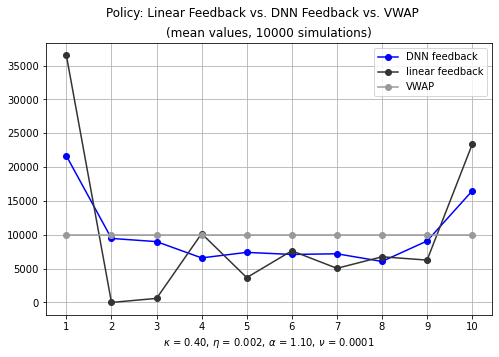

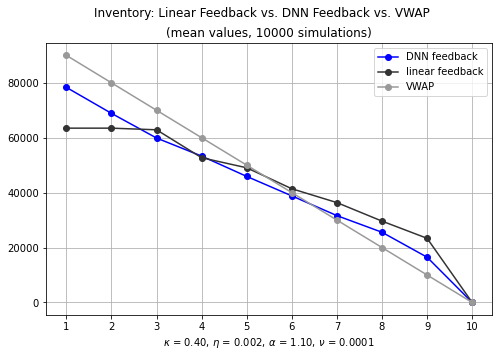

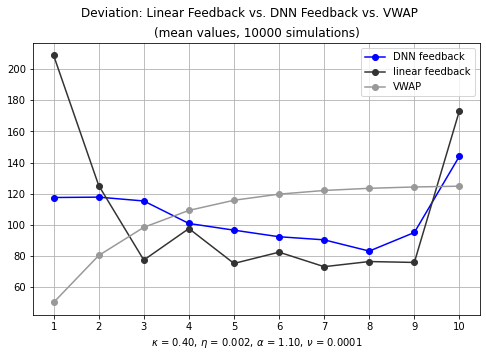

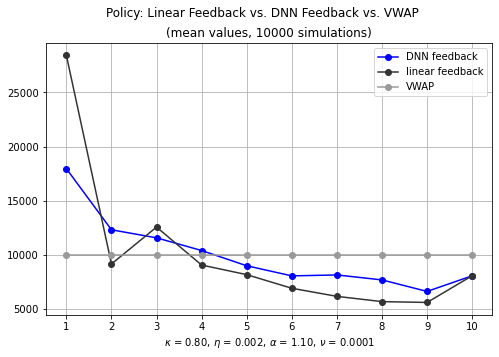

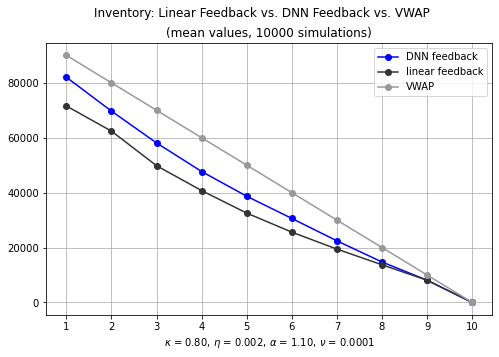

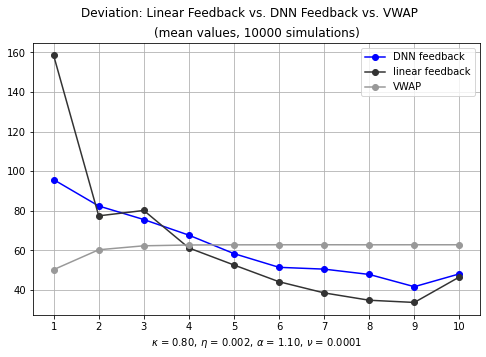

In [22]:
PlotPaths(samplePaths_5D, kappa_test, eta_test, alpha_test, nu_test)

The second set of plots compares the associated execution costs from the NN-trained strategy against the costs from a competitor strategy, namely (1) the <b>(constrained) Linear Feedback strategy</b> and (2) the <b>VWAP strategy</b>; i.e., we compute

\begin{equation*}
\frac{\text{Average Cost Competitor Strategy}-\text{Average Cost NN-strategy} }{\text{Average Cost Competitor Strategy}} \cdot 100
\end{equation*}

and plot a histogram using 10000 simulations. Hence, positive values mean that the NN-trained strategy achieves <i>lower</i> execution costs.

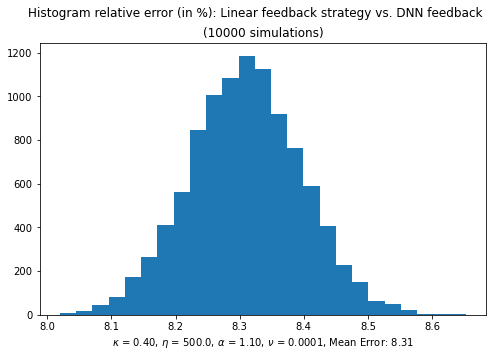

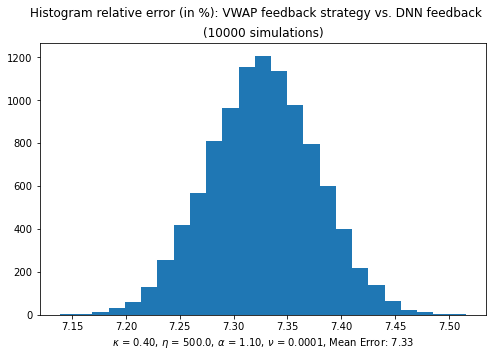

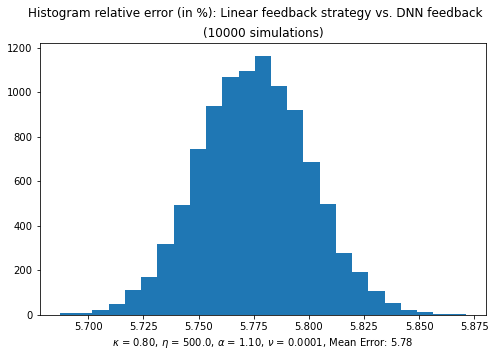

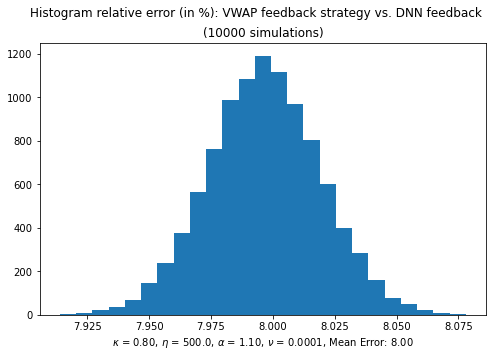

In [23]:
PlotPerformanceHist(samplePaths_5D, kappa_test, eta_test, alpha_test, nu_test)

### Compare different price impact parameter configurations

The last figure below, matching in format Figure 4 (right) in the manuscript compares the average execution strategy from the DNN solver and the one from the (constrained) Linear Feedback rule. We show the two setups with low/high resilience $\kappa$, respectively. 

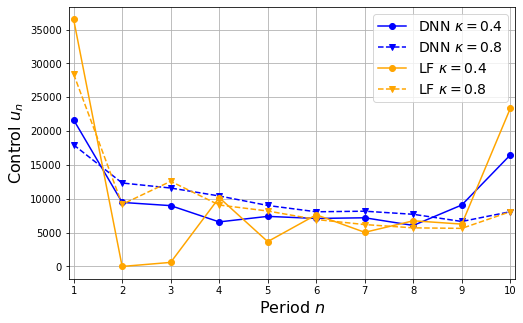

In [24]:
plt.figure(figsize=(8,5))

plt.plot(np.linspace(1,N,N), np.mean(samplePaths_5D[0][0,:,0,1:N+1], axis = 0),
                     '-o', color = 'b', label = "DNN $\kappa = 0.4$")
plt.plot(np.linspace(1,N,N), np.mean(samplePaths_5D[0][1,:,0,1:N+1], axis = 0),
                     '--v', color = 'b', label = "DNN $\kappa = 0.8$")
plt.plot(np.linspace(1,N,N), np.mean(samplePaths_5D[1][0,:,0,1:N+1], axis = 0),
                     '-o', color='orange', label = "LF $\kappa = 0.4$")
plt.plot(np.linspace(1,N,N), np.mean(samplePaths_5D[1][1,:,0,1:N+1], axis = 0),
                     '--v', color='orange', label = "LF $\kappa = 0.8$")

plt.grid()
plt.xlim([0.9,10.1])
plt.xticks(np.linspace(1,N,N))
plt.xlabel("Period $n$",fontsize=16)
plt.ylabel("Control $u_n$",fontsize=16)
plt.legend(fontsize=14)

plt.show()